In [2]:
import ee
ee.Initialize()

import geojson
from shapely import geometry
import pandas as pd
import geopandas as gpd

from e_sbae import hexagonal_grid, plot_samples
from e_sbae import landsat_collection, extract_time_series

/home/sepal-user/venv/eSBAE/lib/python3.8/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


In [28]:
from pathlib import Path
import json
import geojson
import geopandas as gpd
import pandas as pd
files = []
outdir = 'results'
for file in Path(outdir).joinpath('tmp').glob('*geojson'):
    with open(file, 'r') as outfile:
        d = gpd.GeoDataFrame.from_features(geojson.loads(geojson.load(outfile))).drop(['dates', 'ts', 'images', 'geometry'], axis=1)
        #print(len(d), file)
        files.append(d)
    
newdf = pd.concat(files)

In [29]:
len(newdf)

91209

In [8]:
newdf.drop(['dates', 'ts'], axis=1).to_file('test.gpkg', driver='GPKG')

In [11]:
import time


In [23]:
time.strftime("%y%m%d_%H%M%S", time.gmtime())

'230317_082738'

In [57]:
from e_sbae.helpers.ee import processing_grid
import ee
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

# put in your EE feture collection
points = ee.FeatureCollection(
    "users/andreasvollrath/eth_ts_analysis/ethiopia_hex_centroids_dggrid_15"
).sort('point_id')
sub = ee.FeatureCollection(points.toList(25000))
chunks = processing_grid(ee.FeatureCollection(sub.geometry().convexHull(100)), 0.125)
print(chunks.size().getInfo())
toProc = chunks.map(lambda x: ee.Feature(x).set('intersects', sub.filterBounds(x.geometry()).size()))
toProc.filter(ee.Filter.And(
    ee.Filter.gt('intersects', 0),
    ee.Filter.lt('intersects', 50)
)).size().getInfo()



663


136

In [54]:
toProc.first().getInfo()

{'type': 'Feature',
 'geometry': {'geodesic': False,
  'type': 'Polygon',
  'coordinates': [[[33.06138998368152, 8.2657604579625],
    [33.18638998368152, 8.2657604579625],
    [33.18638998368152, 8.3907604579625],
    [33.06138998368152, 8.3907604579625],
    [33.06138998368152, 8.2657604579625]]]},
 'id': '476',
 'properties': {'intersects': 0}}

Creating hexagonal grid...
** executing DGGRID version 7.7 **
type sizes: big int: 64 bits / big double: 128 bits

** loading meta file /home/sepal-user/tmp/tmp_meta_a6db0e7e-5820-41f5-954e-05c385ea3471...
* using parameter values:
dggrid_operation GENERATE_GRID (user set)
dggs_type ISEA3H (user set)
dggs_topology HEXAGON (user set)
dggs_proj ISEA (user set)
dggs_aperture_type PURE (user set)
dggs_aperture 3 (user set)
proj_datum WGS84_AUTHALIC_SPHERE (default)
dggs_orient_specify_type SPECIFIED (user set)
dggs_num_placements 1 (user set)
dggs_orient_output_file_name grid.meta (default)
dggs_vert0_lon 11.25 (user set)
dggs_vert0_lat 58.2825 (user set)
dggs_vert0_azimuth 0 (user set)
dggs_res_specify_type SPECIFIED (user set)
dggs_res_spec 7 (user set)
rng_type RAND (default)
geodetic_densify 0 (default)
clip_subset_type SHAPEFILE (user set)
clip_cell_seqnums  (default)
clip_cell_res 1 (default)
clip_cell_densification 1 (default)
clip_region_files /home/sepal-user/tmp/tmp_extent_a6db0e

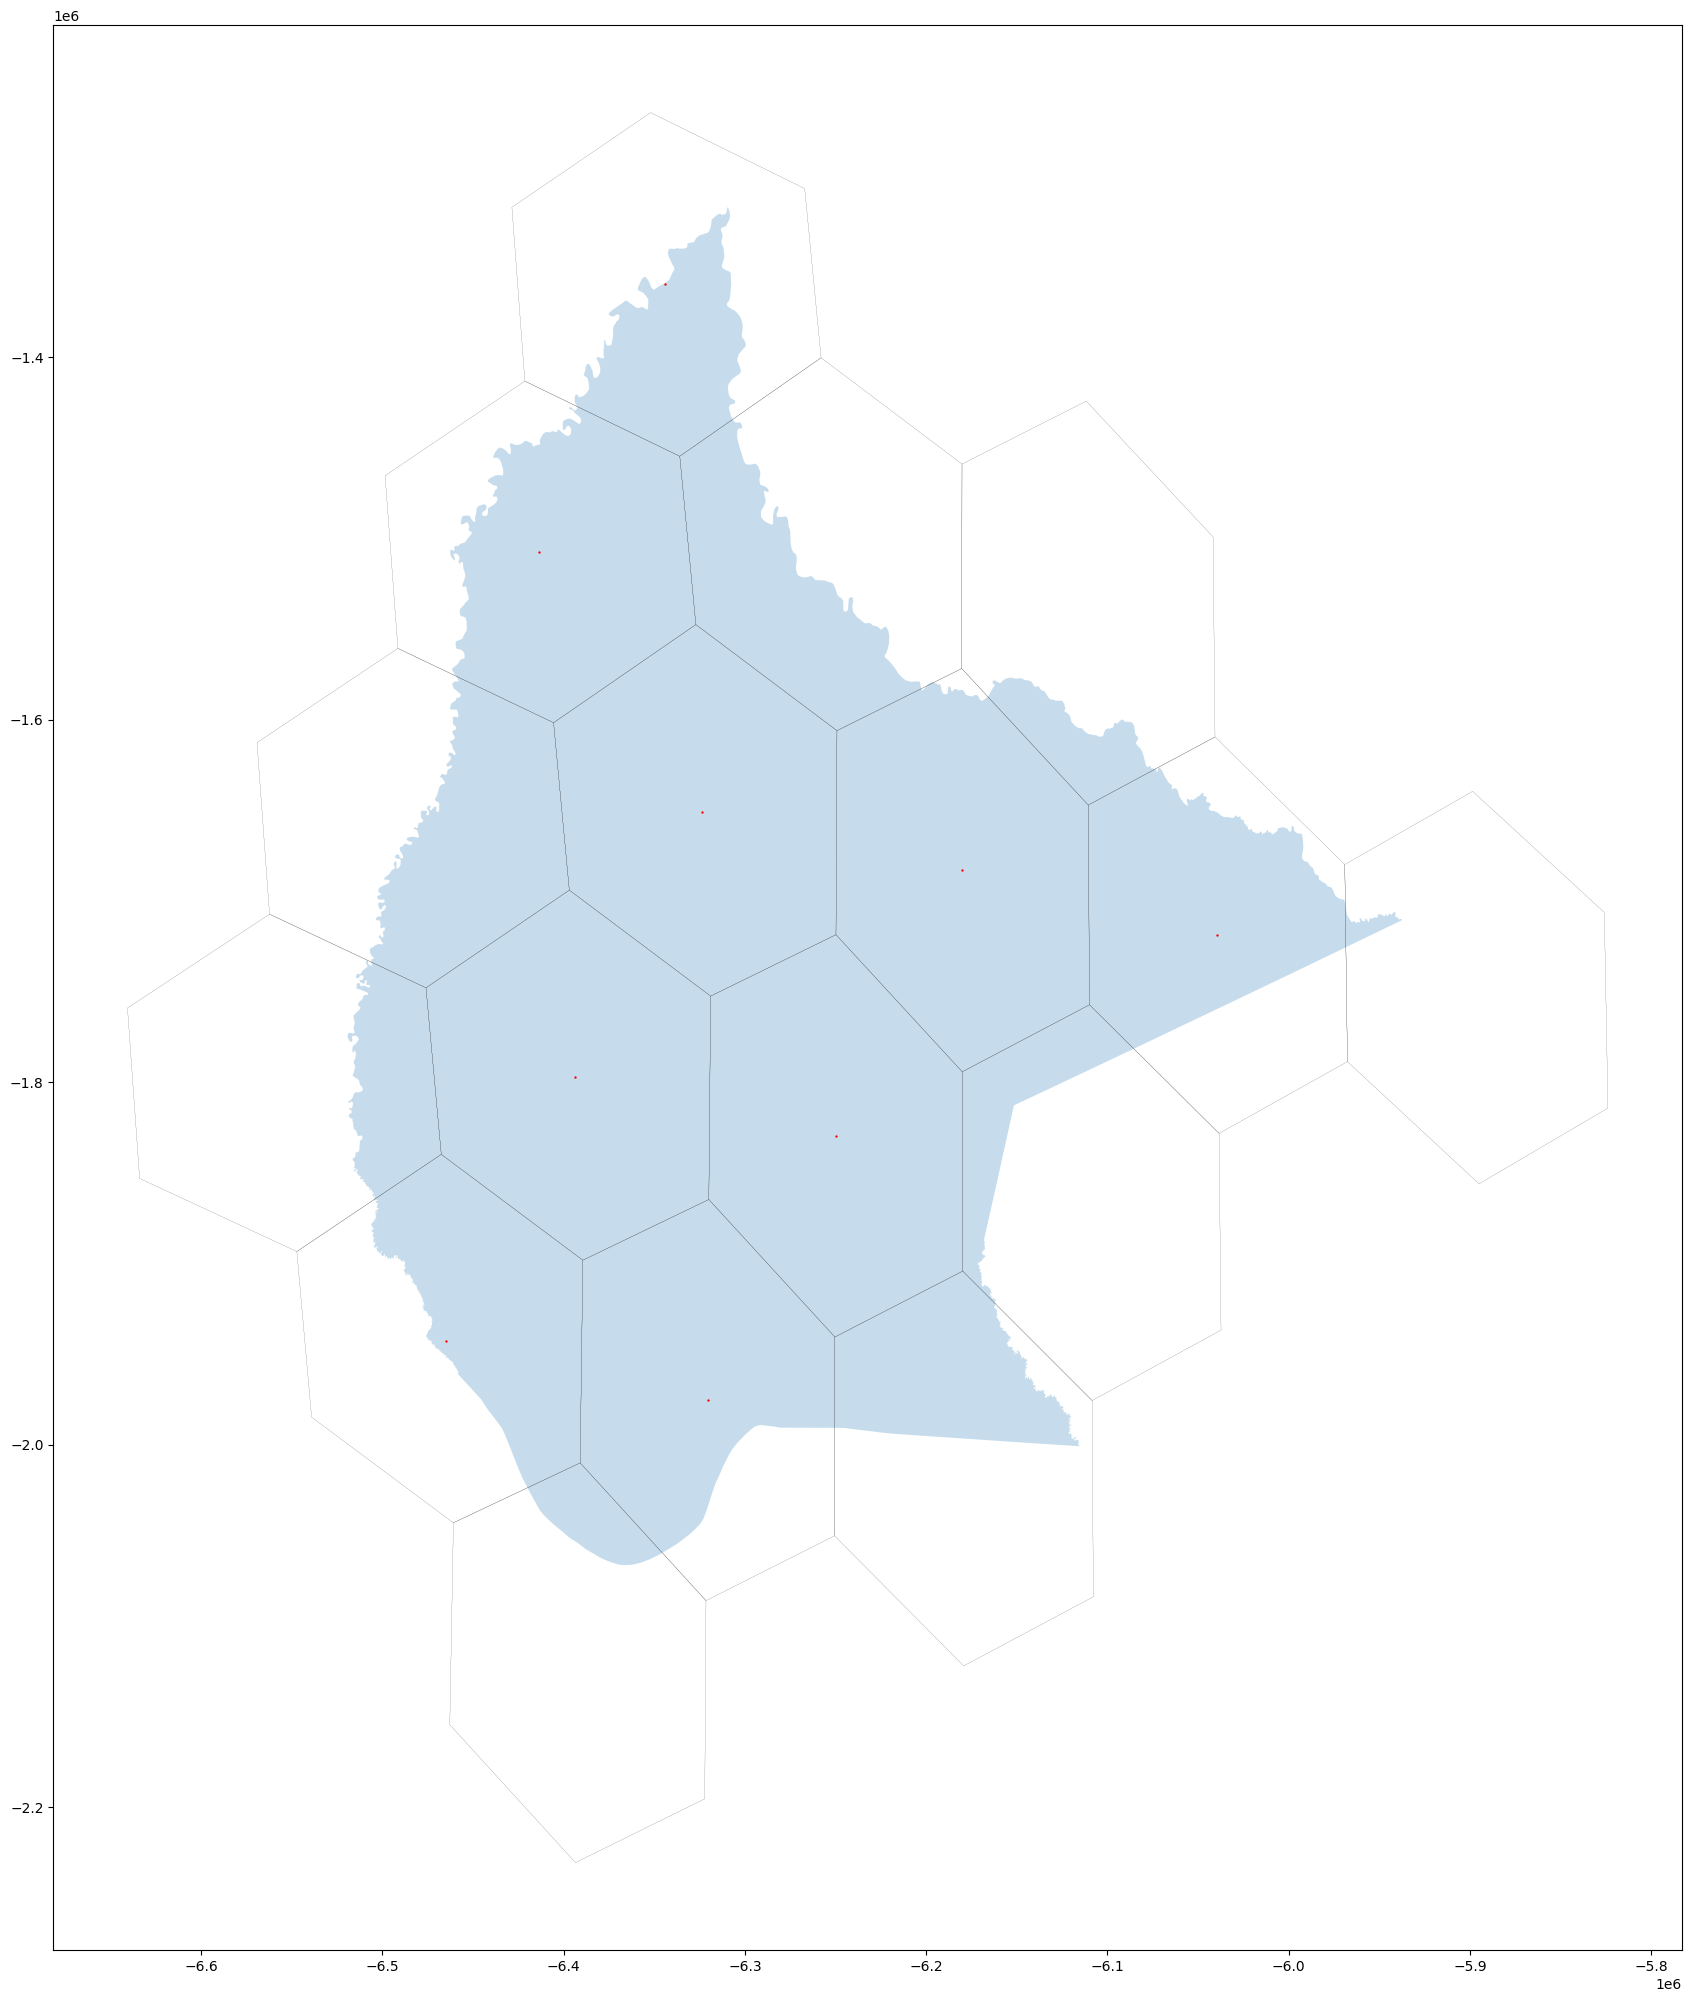

In [3]:
aoi = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM1_NAME', 'Beni'))
cells, points = hexagonal_grid(aoi, 7)
plot_samples(aoi, points, cells)

In [17]:
import numpy as np
l = [1]
if l:
    print('here')

here


In [ ]:
import eSBAE

In [ ]:
# re-create a dataframe
d = {
    'dates': [['2022-10-10','2022-11-10','2023-01-01','2023-04-01']],
    'ts': [{
        'red': [543.34, 363.42, 6456.4, 345],
        'ndfi': [54.34, 36.42, 645.4, 35]
    }],
    'geometry': [geometry.Point(0, 0)]
}

df = pd.DataFrame.from_dict(d, orient='columns')
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [ ]:
# this is how we dump
with open('test.geojson', 'w') as outfile:
     geojson.dump(gdf.to_json(), outfile)

In [ ]:
# this is how we load
with open('test.geojson', 'r') as outfile:
    d = gpd.GeoDataFrame.from_features(geojson.loads(geojson.load(outfile)))

In [ ]:
# alternative, needs pyarrow
d.to_parquet('test.parquet')

In [4]:
grid = gpd.read_file('/home/sepal-user/Ethiopia/grids/fine_grid_points_biomes_res15_esri54017.gpkg')


In [35]:
start_res = 10
for resolution in range(start_res, start_res-3, -1):
    print(resolution)

10
9
8


In [32]:
def create_processing_grid(input_grid, resolution):
    """ A function to creresolutiongrid over a given set of points using dggrid
    """

    # create a polygon surrounding all points
    aoi = gpd.GeoDataFrame(
        index=[0],
        crs=input_grid.crs,
        geometry=[input_grid.geometry.unary_union.convex_hull]
    )

    # run dggrid routine at given resolution scale
    cells, _ = hexagonal_grid(aoi, resolution, outcrs='epsg:4326')
    return cells


p, grid_cells = 0, create_processing_grid(grid, 10)
for i, row in grid_cells.iterrows():
    
    points = grid[grid.to_crs('epsg:4326').intersects(row.geometry)]
    print(len(points))
    p += len(points)

print(p)

Creating hexagonal grid...
** executing DGGRID version 7.7 **
type sizes: big int: 64 bits / big double: 128 bits

** loading meta file /home/sepal-user/tmp/tmp_meta_080afd73-638b-4c72-b8b5-8e18e3904f01...
* using parameter values:
dggrid_operation GENERATE_GRID (user set)
dggs_type ISEA3H (user set)
dggs_topology HEXAGON (user set)
dggs_proj ISEA (user set)
dggs_aperture_type PURE (user set)
dggs_aperture 3 (user set)
proj_datum WGS84_AUTHALIC_SPHERE (default)
dggs_orient_specify_type SPECIFIED (user set)
dggs_num_placements 1 (user set)
dggs_orient_output_file_name grid.meta (default)
dggs_vert0_lon 11.25 (user set)
dggs_vert0_lat 58.2825 (user set)
dggs_vert0_azimuth 0 (user set)
dggs_res_specify_type SPECIFIED (user set)
dggs_res_spec 10 (user set)
rng_type RAND (default)
geodetic_densify 0 (default)
clip_subset_type SHAPEFILE (user set)
clip_cell_seqnums  (default)
clip_cell_res 1 (default)
clip_cell_densification 1 (default)
clip_region_files /home/sepal-user/tmp/tmp_extent_080af

/home/sepal-user/modules/eSBAE/e_sbae/sampling/grid.py:214: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["sample_points"] = gdf.geometry.centroid


Adding a unique point ID...
Remove points outside AOI...
Sampling grid consists of 1524 points.
0
24
0
0
16
188
178
0
0
1
0
0
57
164
242
243
209
122
0
8
0
24
33
109
189
111
46
202
242
243
244
242
244
206
193
3
0
8
139
239
243
243
244
214
244
242
243
243
242
243
242
243
0
107
216
37
105
243
243
243
243
243
243
243
243
244
243
244
243
244
243
0
0
32
161
235
223
204
243
243
243
243
243
243
243
243
243
242
243
242
244
242
0
0
0
30
170
243
243
243
243
244
243
243
243
243
243
243
243
242
242
244
243
244
242
12
0
0
0
98
243
243
243
235
242
243
244
243
243
243
243
243
242
243
244
244
242
243
242
53
187
94
0
0
148
243
243
243
243
244
242
242
243
243
243
243
243
243
244
243
243
243
244
243
150
243
243
96
21
212
243
243
243
243
235
243
243
243
243
243
243
242
243
243
242
243
242
243
242
0
212
243
243
235
243
243
243
243
243
243
244
244
243
243
243
243
243
243
243
243
244
242
244
243
0
0
229
243
243
243
243
243
243
243
243
235
243
244
243
244
243
243
243
244
242
243
243
244
242
0
78
243
243
243
24


KeyboardInterrupt



In [20]:

aoi = gpd.GeoDataFrame(index=[0], crs=grid.crs, geometry=[grid.geometry.unary_union.convex_hull])
print(aoi)
#aoi.crs = grid.crs
cells, points = hexagonal_grid(aoi, 7)

                                            geometry
0  POLYGON ((3813062.973 432890.491, 3678854.086 ...
Creating hexagonal grid...
** executing DGGRID version 7.7 **
type sizes: big int: 64 bits / big double: 128 bits

** loading meta file /home/sepal-user/tmp/tmp_meta_e5000857-d6c2-4d91-b425-f8ddcf4662ac...
* using parameter values:
dggrid_operation GENERATE_GRID (user set)
dggs_type ISEA3H (user set)
dggs_topology HEXAGON (user set)
dggs_proj ISEA (user set)
dggs_aperture_type PURE (user set)
dggs_aperture 3 (user set)
proj_datum WGS84_AUTHALIC_SPHERE (default)
dggs_orient_specify_type SPECIFIED (user set)
dggs_num_placements 1 (user set)
dggs_orient_output_file_name grid.meta (default)
dggs_vert0_lon 11.25 (user set)
dggs_vert0_lat 58.2825 (user set)
dggs_vert0_azimuth 0 (user set)
dggs_res_specify_type SPECIFIED (user set)
dggs_res_spec 7 (user set)
rng_type RAND (default)
geodetic_densify 0 (default)
clip_subset_type SHAPEFILE (user set)
clip_cell_seqnums  (default)
clip_cell_re

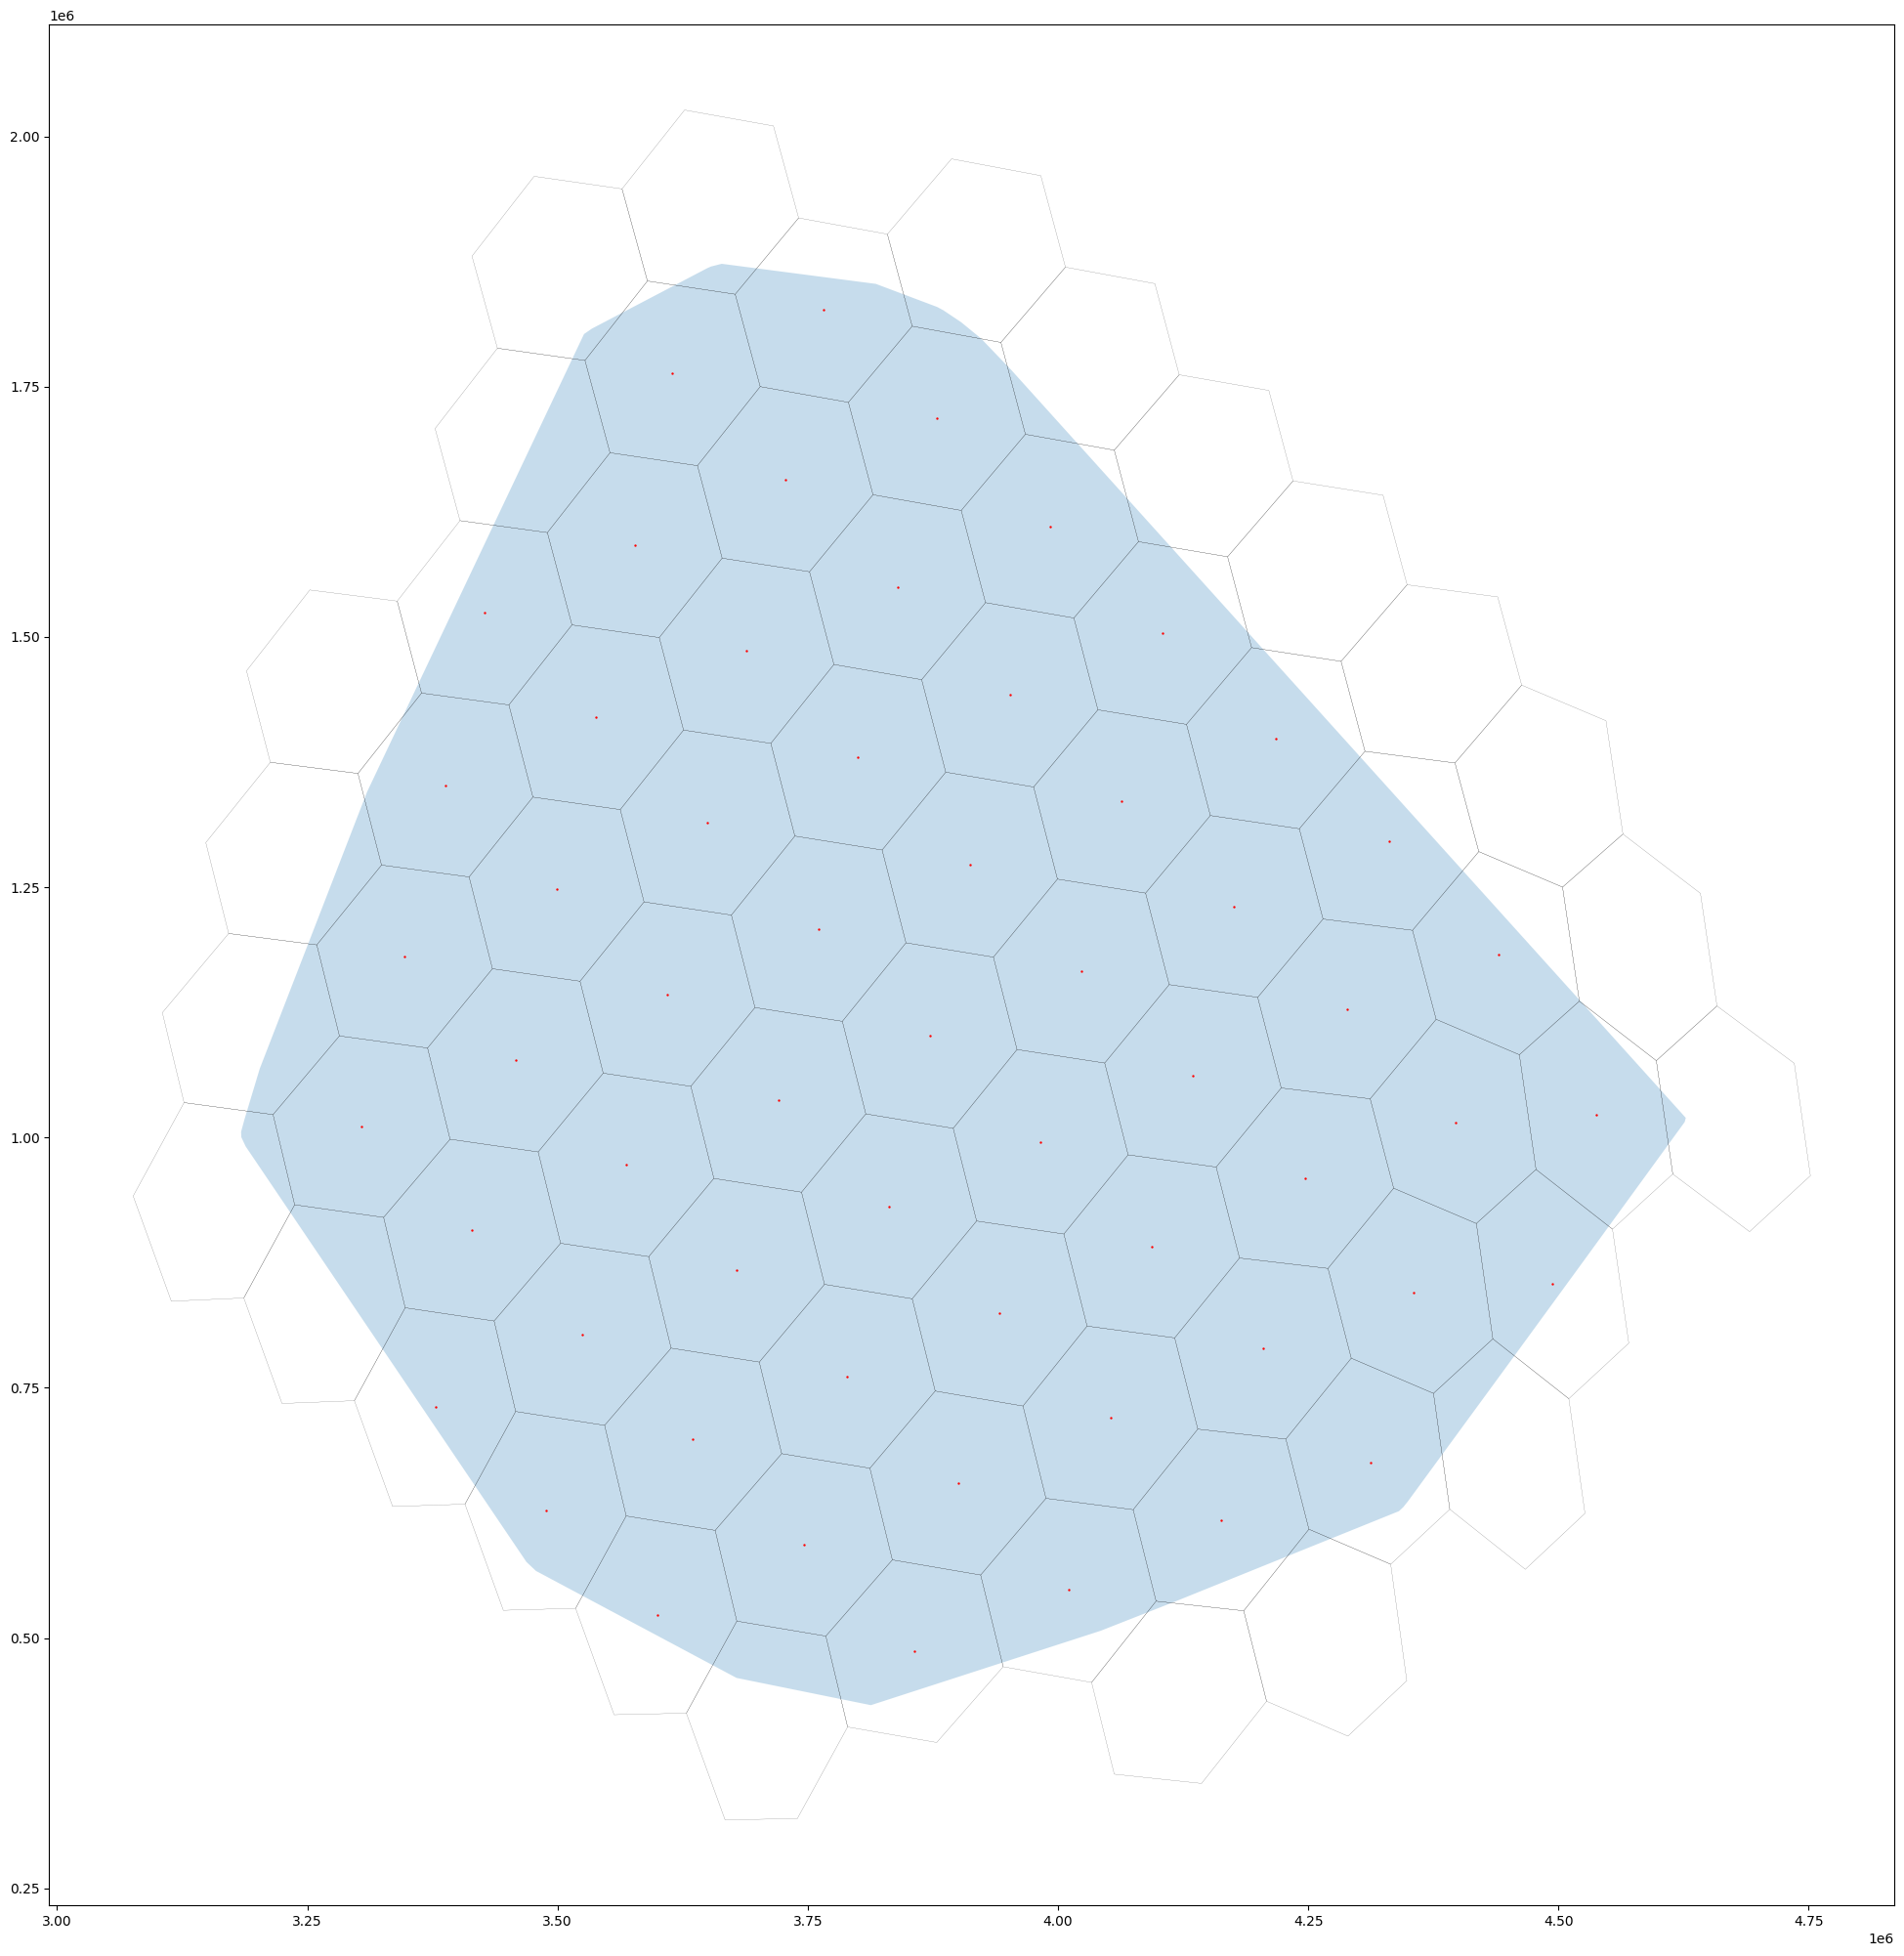

In [21]:
plot_samples(aoi, points, cells)

In [ ]:
import dask_geopandas

partitions = int(len(grid)/200)
print(partitions)
d_gdf = dask_geopandas.from_geopandas(grid, npartitions=4)
# create hilbert curve and sort by distance

grid['hilbert_distance'] = d_gdf.geometry.hilbert_distance()
grid = grid.sort_values('hilbert_distance').reset_index()

In [ ]:
grid.head(200)

In [ ]:
#d_gdf.calculate_spatial_partitions() # convex hull
geohash = d_gdf.spatial_shuffle(by="hilbert")
geohash.spatial_partitions.plot(cmap="tab20", alpha=0.1, figsize=(20,20))


In [3]:
gdf = grid.tail(20)
gdf['point_id'] = gdf.index
geo_json = gdf[['point_id', 'geometry']].to_crs('epsg:4326').to_json()
fc = ee.FeatureCollection(json.loads(geo_json))

/home/sepal-user/venv/eSBAE/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [4]:
point_id_name = 'point_id'
# start of calibration period (mainly for bfast)
start_calibration = "2015-01-01"  # YYYY-MM-DD format

# Actual period of interest, i.e. monitoring period
start_monitor =     "2016-01-01"  # YYYY-MM-DD format
end_monitor =       "2017-01-01"  # YYYY-MM-DD format

# Directory where output and temp files will go
outdir = 'results'  # goes to module_results/sbae_point_analysis if set to None

# Select algorithms to run (Treu or False)
cusum_deforest =  True
bfast_monitor =   True
bs_slope =        True
ts_metrics =      True
ccdc =            True
landtrendr =      True
jrc_nrt =         True
global_products = True

# select the bands to extract
bands = ['green', 'red', 'nir', 'swir1', 'swir2', 'ndfi'] # other choices: ndfi, ndmi, mndwi, brightness, greenness, wetness

# select the band for univariate ts-analysis (has to be inside bands list)
ts_band = 'ndfi'

# select the resolution to which the satellite data will be resized.
scale = 70  # in meters (70 m is half ha, relates to FAO forest definition)

### DO NOT CHANGE YET ###
satellite='Landsat'  # this is going to be Surface Reflactance, Collection 2, Tier 1 data only
max_cloud_cover = 75  # in percentage (0-100)

# landsat related parameters
lsat_params = {
    'l9':     True,
    'l8':     True,
    'l7':     True,
    'l5':     True,
    'l4':     True,
    'brdf':   True,
    'bands':  bands,
    'max_cc': max_cloud_cover
}

# bfast parameters
bfast_params = {
    'run':           bfast_monitor,
    'start_monitor': start_monitor, 
    'freq':          365,
    'k':             3, 
    'hfrac':         0.25, 
    'trend':         True, 
    'level':         0.05, 
    'backend':       'python'
}

# cusum parameters
cusum_params = {
    'run':              cusum_deforest,
    'nr_of_bootstraps': 1000
}

# slope parameters
bs_slope_params = {
    'run':              bs_slope,
    'nr_of_bootstraps': 1000
}

# time-series metrics
ts_metrics_params = {
    'run':              ts_metrics,
    'outlier_removal':  False,
    'z_threshhold':     3
}

# ccdc parameters
ccdc_params = {
    'run':                   ccdc,
    'breakpointBands':       ['green', 'red', 'nir', 'swir1', 'swir2'],
    'tmaskBands':            ['green', 'swir2'],
    'minObservations':       6,
    'chiSquareProbability':  .99,
    'minNumOfYearsScaler':   1,
    'dateFormat':            2,
    'lambda':                20,
    'maxIterations':         1000
}


landtrendr_params = { 
        'run':                    landtrendr,
        'maxSegments':            6,
        'spikeThreshold':         0.9,
        'vertexCountOvershoot':   3,
        'preventOneYearRecovery': True,
        'recoveryThreshold':      0.25,
        'pvalThreshold':          0.05,
        'bestModelProportion':    0.75,
        'minObservationsNeeded':  3
}

jrc_nrt_params = {
    'run': jrc_nrt
}

# global products parameters
global_products = {
    'run':                      global_products,
    'gfc':                      True,     # will include tree-cover 2000, loss, gain, lossyear
    'tmf':                      True,    # will include deforestation and degradation year for tropical moist forests
    'tmf_years':                True,    # will include classes per year - according to the monitor period
    'esa_lc20':                 True,    # will include ESA LandCover Product class
    'copernicus_lc':            True,    # will include ESA LandCover Product class - acording to the monitoring years
    'esri_lc':                  True,    # will include the classes from ESRI World Cover 2020
    'lang_tree_height':         True,    # returns the Tree Height from Lang et al 2022
    'potapov_tree_height':      True,    # returns the tree height from Potapov et al. 2019 
    'elevation':                True,    # returns elevation, slope and aspect
    'dynamic_world_tree_prob':  True,    # returns Min, Max, Mean and StdDev of the trees probability for the monitoring period
    'dynamic_world_class_mode': True     # returns the mode of the class for the monitoring period   
}

### DO NOT CHANGE ###
### GATHER ALL INFO INTO A DICT #####
config_dict = {
    'work_dir':                         outdir,
    'workers':                          10,
    'max_points_per_chunk':             250,
    'grid_size_levels':                 [4, 2, 1, 0.5, 0.25, 0.125, 0.075],  # definition of chunk sizes in degrees  
    'lsat_params':                      lsat_params,
    'ts_params': {
        'start_calibration':            start_calibration,
        'start_monitor':                start_monitor,
        'end_monitor':                  end_monitor,
        'point_id':                     point_id_name,
        'bands':                        bands,
        'ts_band':                      ts_band,
        'satellite':                    satellite,
        'scale':                        scale,
        'max_cc':                       max_cloud_cover,
        'outlier_removal':              True,
        'smooth_ts':                    True       
    },    
    'bfast_params':                     bfast_params,
    'cusum_params':                     cusum_params,
    'bs_slope_params':                  bs_slope_params,
    'ts_metrics_params':                ts_metrics_params,
    'ccdc_params':                      ccdc_params,
    'landtrendr_params':                landtrendr_params,
    'jrc_nrt_params':                   jrc_nrt_params,
    'global_products':                  global_products
}

In [5]:
# create image collection (not being changed)
lsat = landsat_collection(
    start_calibration, 
    end_monitor, 
    fc.geometry().convexHull(100), 
    **config_dict['lsat_params']
)
extr_df = extract_time_series(lsat, fc, config_dict)

In [11]:
extr_df.to_file('test.gpkg', driver='GPKG')

ValueError: Invalid field type <class 'list'>

In [ ]:
def structure_ts_data(df, point_id_name, bands):
    
    
    df.index = pd.DatetimeIndex(pd.to_datetime(df.imageID.apply(lambda x: x.split('_')[-1]), format='%Y%m%d'))
    df['dates'] = df['imageID'].apply(lambda x: int(x.split('_')[-1]))
    #print(df['dates'])
    #return
    # loop over point_ids and run cusum
    d = {}
    for i, point in enumerate(df[point_id_name].unique()):
        
        # read only orws of points and sort by date
        sub = df[df[point_id_name] == point].sort_index()
        
        #### LANDSAT ONLY ###########
        sub['pathrow'] = sub.imageID.apply(lambda x: x.split('_')[-2])

        # if more than one path row combination covers the point, we select only the one with the most images
        if len(sub.pathrow.unique()) > 1:
            # set an initil length
            length = -1
            # loop through pathrw combinations
            for pathrow in sub.pathrow.unique():
                # check length
                l = len(sub[sub.pathrow == pathrow])
                # compare ot previous length, and if higher reset pathrow and length variable
                if l > length:
                    pr = pathrow
                    length = l
            # finally filter sub df for pathrow with most images
            sub = sub[sub.pathrow == pr]
        #### LANDSAT ONLY ###########
        
        # still duplicates may appear between l9 and l8 that would make bfast crash, so we drop
        sub = sub[~sub.index.duplicated(keep='first')]
        
        # fill ts dictionary
        ts_dict= {}
        for band in bands:
            ts_dict.update({band: sub[band].tolist()})
        
        # write everything to a dict
        d[i] = {
            'point_idx': i,
             point_id_name: point,
            'dates': sub['dates'].tolist(),
            'ts': ts_dict, 
            'images': len(sub),
            'geometry': sub.geometry.head(1).values[0]
        }
    
    # turn the dict into a geodataframe and return
    return gpd.GeoDataFrame(pd.DataFrame.from_dict(d, orient='index')).set_geometry('geometry')

In [ ]:
new = structure_ts_data(extr_df, point_id_name, bands)

In [ ]:
new.head(1).ts[0]['red']